# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct
import src.features.RT_transport as rtt
import src.set_paths as sps
import src.RT_parameters as rtp
import src.features.RT_EOF_functions as rt_eof
import src.features.RT_visualise as rtv

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
date_str_start = '201407'
date_str_end = '202207'
fn_out_version = 'v1'
script_name = f"3.0_Rockall_Trough_transports_{date_str_start[:-2]}_{date_str_end[:-2]}_v1"

# output figures
fig_out_path = (sps.local_fig_dir/f"{script_name}")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
data_out_path = (sps.local_data_dir/f"{script_name}")
Path(data_out_path).mkdir(parents=True, exist_ok=True)

data_out_path_od = (sps.RT_data_path/f"{script_name}")
Path(data_out_path_od).mkdir(parents=True, exist_ok=True)

fn_base_Q = "Rockall_Trough_transport_time_series"
fn_base_grid = "Rockall_Trough_transport_3D_time_series"
fn_base_EK = "Rockall_Trough_Ekman_transport_time_series"

file_name_out_Q = f"{fn_base_Q}_{date_str_start}_{date_str_end}_{fn_out_version}.nc"
file_name_out_grid = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_out_version}.nc"
file_name_out_Ek = f"{fn_base_EK}_{date_str_start}_{date_str_end}_{fn_out_version}.nc"

In [5]:
# intput data
fn_in_version = 'v1'
fn_base_grid = "Rockall_Trough_mooring_gridded_TSUV"
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"

RT_mooring_fn = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_in_version}.nc"
file_name_in_stack = f"{fn_base_stack}_{date_str_start}_{date_str_end}_{fn_in_version}.nc"

## Load Data and prepare for calculations

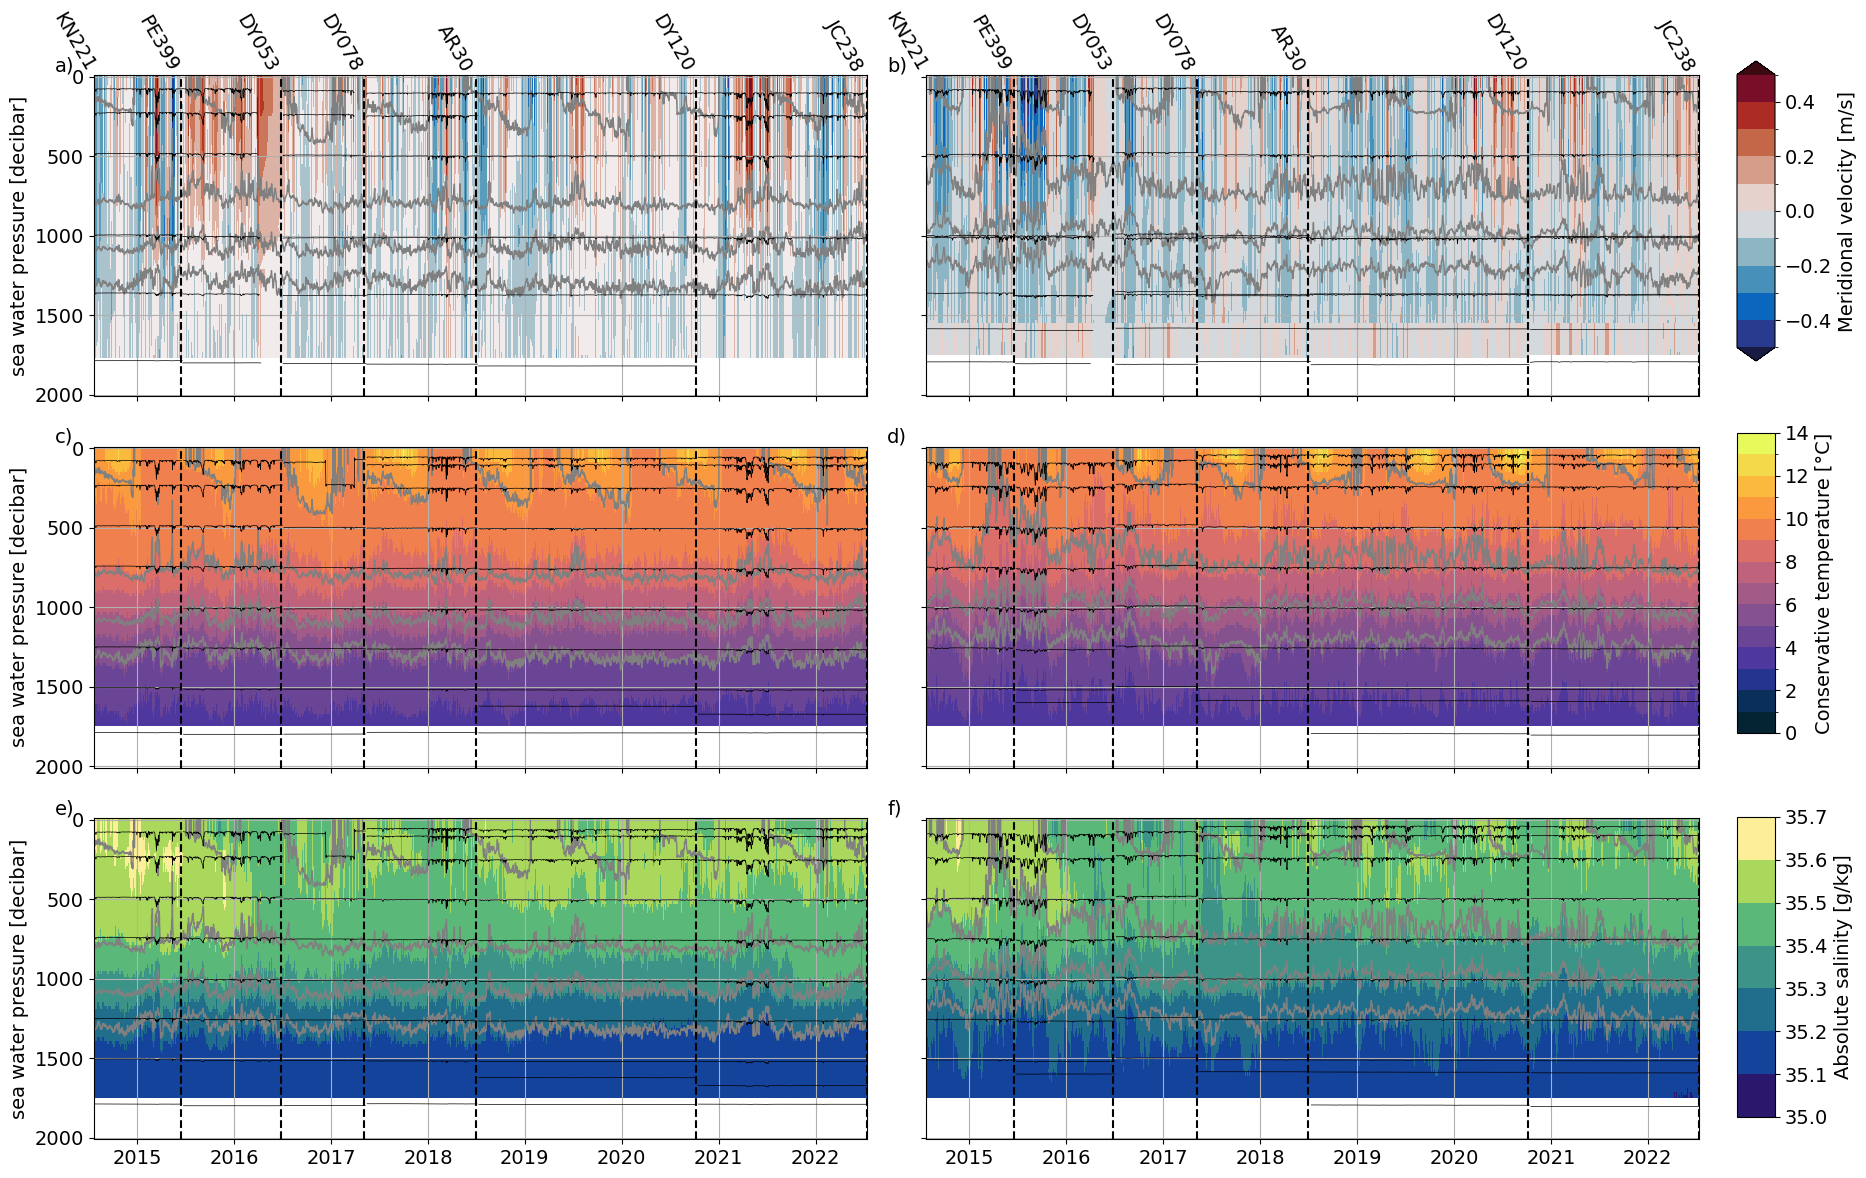

In [6]:
# Rockall Trough mooring location
ds_RT_loc=rtd.load_RT_loc()

# stacked RT mooing data
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

# load gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/RT_mooring_fn))

# Extrapolate top and linearly interpolate over gaps
ds_RT = rtf.prep_mooring_data_for_transport_calc(ds_RT,ds_RT_loc)

fig = rtv.plot_moorings_paper(ds_RT,ds_RT_stacked)
# fig.savefig(fig_out_path/f'RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png',bbox_inches='tight')

In [7]:
#load glider
ds_glider = matlab_fct.load_glider_mat(sps.glider_data_path,sps.glider_fn)
ds_glider_nan = rt_eof.add_nan_glider_sections(ds_glider)

In [8]:
# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((sps.GEBCO_data_path/sps.GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS = rtd.load_glorys('RTADCP',ds_RT.TIME.min(),ds_RT.TIME.max())

# load ERA5
ds_ERA5 = xr.open_dataset((sps.ERA5_data_path/sps.ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

Data is in GLORYS reanlysis and interim period


# Calculations

## Horizontal and vertical grid parameters

In [9]:
RT_hor_grid = rtt.create_horizontal_grid('v1')

In [10]:
# Get dz (top/bottom cells are ~10m thick, cells are ~20m thick elsewhere)
dz = rtt.get_dz(ds_RT.depth)
ds_RT['dz']=xr.DataArray(dz,dims='depth')

## Midbasin transport based on no motion at 1760 dbar

CPU times: total: 4.06 s
Wall time: 4.06 s


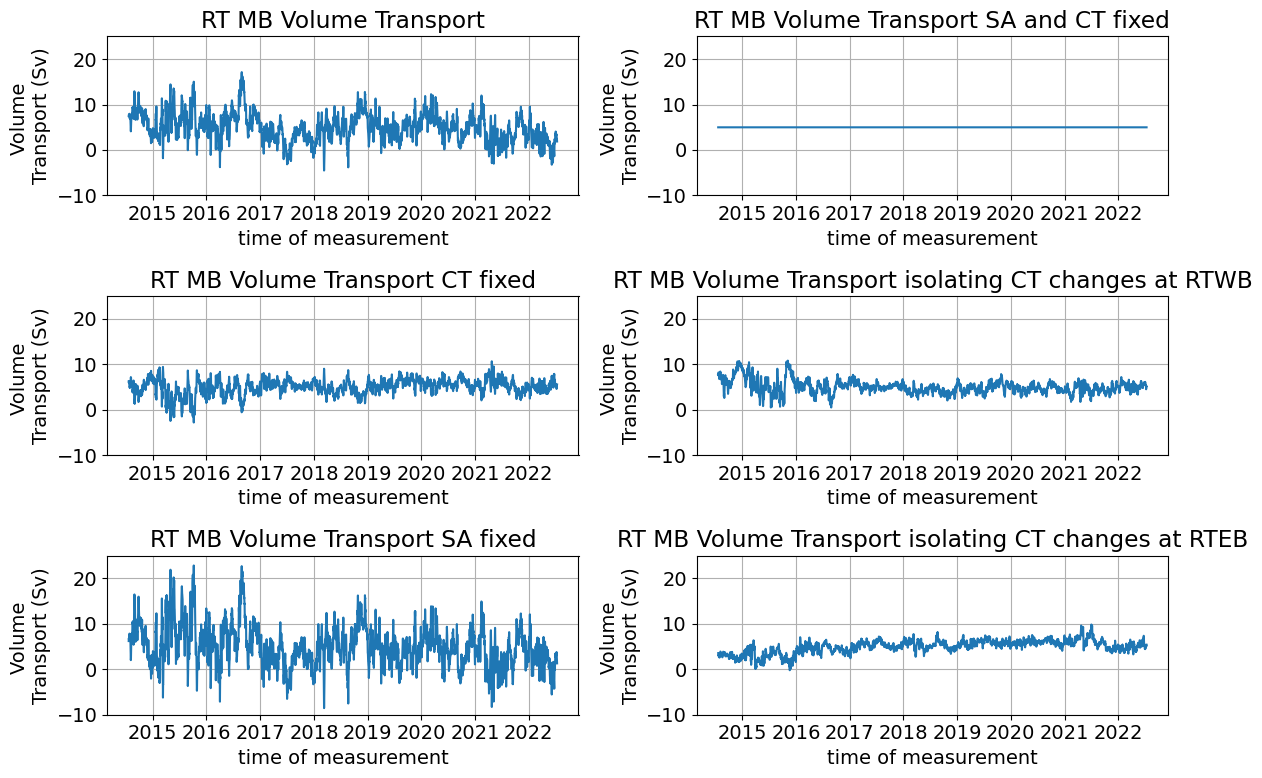

In [11]:
%%time
RT_Q_MB,q_MB = rtt.calc_MB_transport(ds_RT,ds_RT_loc,sens_analysis=True,check_plots=True)

In [12]:
%%time
# create MB matrix, fine horizontal grid, new and not in Fraser et al. (2022)
ds_RT_MB_grid = rtt.calc_MB_3D_sections(ds_RT,ds_RT_loc,RT_hor_grid)

CPU times: total: 51.6 s
Wall time: 51.7 s


## Western wedge transport

CPU times: total: 2min 11s
Wall time: 2min 11s


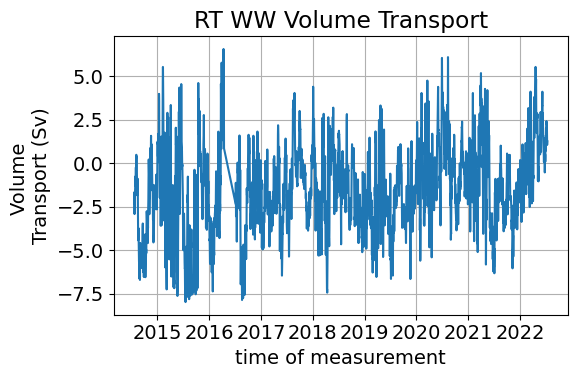

In [13]:
%%time
Q_WW, ds_RT_WW_grid = rtt.calc_WW_transport(ds_RT,ds_RT_loc,RT_hor_grid,ds_GEBCO)

## Eastern wedge

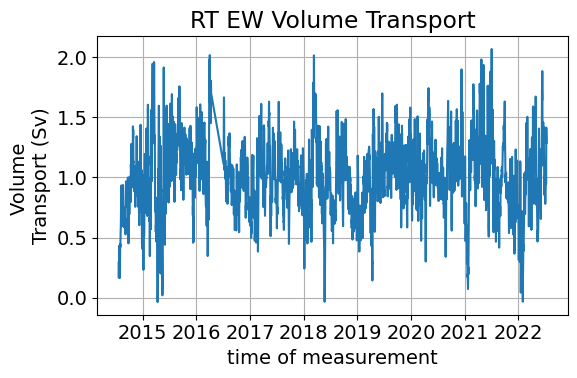

In [14]:
Q_EW, ds_RT_EW_grid = rtt.calc_EW_transport(ds_RT,ds_RT_loc,RT_hor_grid,ds_glider,
                                        ds_GEBCO,ds_GLORYS,check_plots=True)

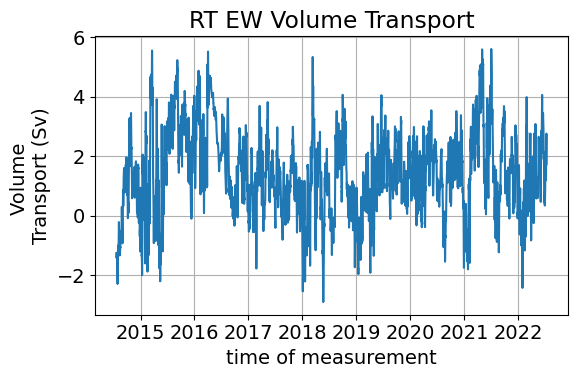

In [15]:
Q_EW_F22, ds_RT_EW_F22_grid = rtt.calc_EW_F22_transport(ds_RT,ds_RT_loc,RT_hor_grid,
                                                    ds_GEBCO,ds_GLORYS,check_plots=True)

## Ekman transport

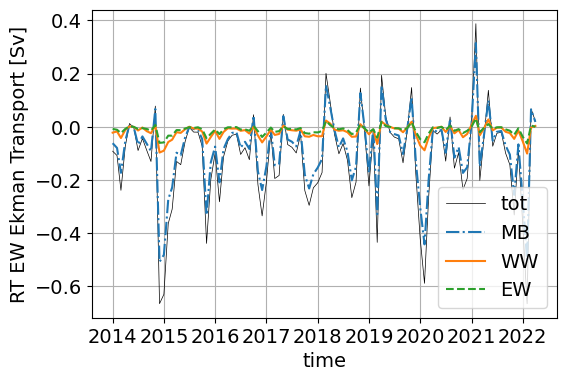

In [16]:
RT_Q_Ek = rtt.calc_Ekman_transport(ds_ERA5, RT_hor_grid,ds_RT_loc,check_plots=True)

## Heat and Freshwater Fluxes

In [17]:
# Get SA and CT fields - interpolate for midbasin
ds_RT['SG_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
ds_RT['TG_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

In [18]:
ds_Q_MB,ds_q_MB = rtt.calc_transports(RT_Q_MB.RT_Q_MB,q_MB.drop_vars(['lat','lon']),
                                  ds_RT.TG_MB,ds_RT.SG_MB,
                                  ['depth'],'MB')
ds_Q_EW,ds_q_EW = rtt.calc_transports(Q_EW,ds_RT_EW_grid.q,ds_RT.TG_EAST,ds_RT.SG_EAST,
                                  ['depth','lon'],'EW')
ds_Q_WW,ds_q_WW = rtt.calc_transports(Q_WW,ds_RT_WW_grid.q,ds_RT.TG_WEST,ds_RT.SG_WEST,
                                  ['depth','lon'],'WW')

In [19]:
ds_RT_EW_grid = rtt.add_da_to_ds(ds_RT_EW_grid,ds_q_EW)
ds_RT_WW_grid = rtt.add_da_to_ds(ds_RT_WW_grid,ds_q_WW)

In [20]:
ds_Q_tot = rtt.combine_sections_tot_transp(ds_Q_WW,ds_Q_MB,ds_Q_EW)

In [21]:
# finer grid MB
# Compute transports in each cell
ds_Q_MB_grid,ds_q_MB_grid = rtt.calc_transports(RT_Q_MB.RT_Q_MB,ds_RT_MB_grid.q,
                                  ds_RT.TG_MB,ds_RT.SG_MB,
                                  ['depth','lon'],'MB')

ds_RT_MB_grid = rtt.add_da_to_ds(ds_RT_MB_grid,ds_q_MB_grid)

In [22]:
# Isolate changes in velocity, mean tracer 
ds_Q1_MB,ds_q1_MB = rtt.calc_transports(RT_Q_MB.RT_Q_MB,q_MB.drop_vars(['lat','lon']),
                ds_RT.TG_MB.mean('TIME'),ds_RT.SG_MB.mean('TIME'),
                ['depth'],'MB_TSfix')
ds_Q1_EW,ds_q1_EW = rtt.calc_transports(Q_EW,ds_RT_EW_grid.q,
                ds_RT.TG_EAST.mean('TIME'),ds_RT.SG_EAST.mean('TIME'),
                ['depth','lon'],'EW_TSfix')
ds_Q1_WW,ds_q1_WW = rtt.calc_transports(Q_WW,ds_RT_WW_grid.q,
                ds_RT.TG_WEST.mean('TIME'),ds_RT.SG_WEST.mean('TIME'),
                ['depth','lon'],'WW_TSfix')

# Isolate changes in tracer, mean velocity
ds_Q2_MB,ds_q2_MB = rtt.calc_transports(RT_Q_MB.RT_Q_MB.mean('TIME'),q_MB.mean('TIME').drop_vars(['lat','lon']),
                ds_RT.TG_MB,ds_RT.SG_MB,
                ['depth'],'MB_qfix')
ds_Q2_EW,ds_q2_EW = rtt.calc_transports(Q_EW.mean('TIME'),ds_RT_EW_grid.q.mean('TIME'),
                ds_RT.TG_EAST,ds_RT.SG_EAST,
                ['depth','lon'],'EW_qfix')
ds_Q2_WW,ds_q2_WW = rtt.calc_transports(Q_WW.mean('TIME'),ds_RT_WW_grid.q.mean('TIME'),
                ds_RT.TG_WEST,ds_RT.SG_WEST,
                ['depth','lon'],'WW_qfix')

## Apply low pass filter

Q has length 1, no filter applied
Q has length 1, no filter applied
Q has length 1, no filter applied


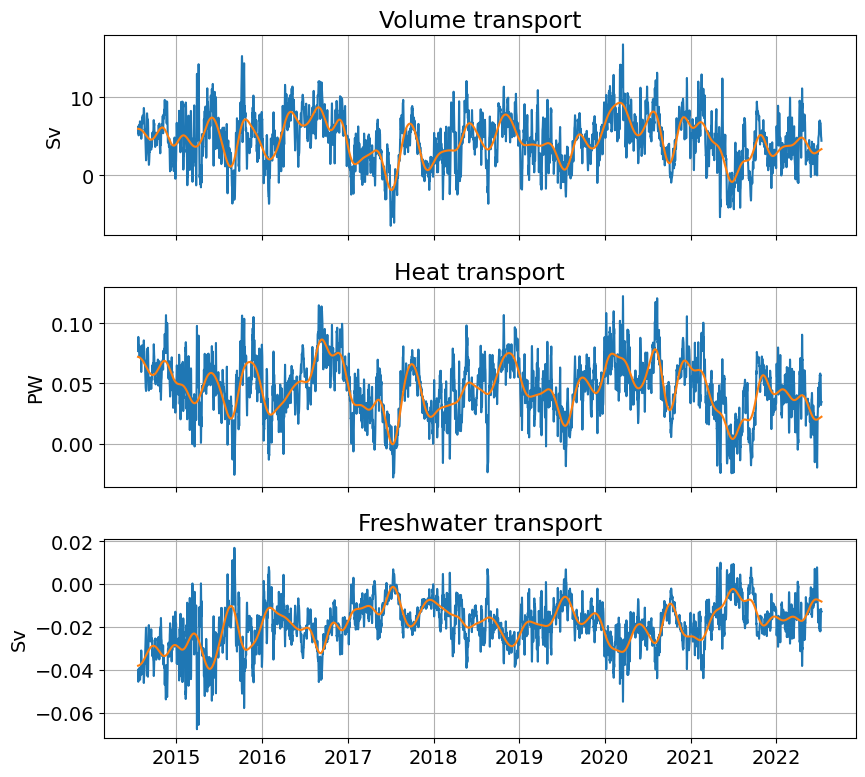

In [23]:
#low pass filter
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/rtp.filter_length # cut off frequency

ds_Q_MB = rtf.lp_filt_loop(ds_Q_MB,lowcut,fs,'TIME')
ds_Q_EW = rtf.lp_filt_loop(ds_Q_EW,lowcut,fs,'TIME')
ds_Q_WW = rtf.lp_filt_loop(ds_Q_WW,lowcut,fs,'TIME')
ds_Q_tot = rtf.lp_filt_loop(ds_Q_tot,lowcut,fs,'TIME',check_plots=True)

ds_Q1_MB = rtf.lp_filt_loop(ds_Q1_MB,lowcut,fs,'TIME')
ds_Q1_EW = rtf.lp_filt_loop(ds_Q1_EW,lowcut,fs,'TIME')
ds_Q1_WW = rtf.lp_filt_loop(ds_Q1_WW,lowcut,fs,'TIME')

ds_Q2_MB = rtf.lp_filt_loop(ds_Q2_MB,lowcut,fs,'TIME')
ds_Q2_EW = rtf.lp_filt_loop(ds_Q2_EW,lowcut,fs,'TIME')
ds_Q2_WW = rtf.lp_filt_loop(ds_Q2_WW,lowcut,fs,'TIME')

## Calculate Standard errors

In [24]:
%%time
ds_Q_MB = rtf.std_error_loop(ds_Q_MB)
ds_Q_EW = rtf.std_error_loop(ds_Q_EW)
ds_Q_WW = rtf.std_error_loop(ds_Q_WW)
ds_Q_tot = rtf.std_error_loop(ds_Q_tot)

CPU times: total: 188 ms
Wall time: 232 ms


In [25]:
print('tot transport errors')
print(ds_Q_tot.Q_total_SE.values)
print(ds_Q_tot.Qh_total_SE.values)
print(ds_Q_tot.Qf_total_SE.values)

print('Midbasin non-grid')
print(ds_Q_MB.Q_SE.values)
print(ds_Q_MB.Qh_SE.values)
print(ds_Q_MB.Qf_SE.values)

tot transport errors
0.4415216105275456
0.0032051548335724584
0.0019337605374624334
Midbasin non-grid
0.48292017572269225
0.0033524562888948397
0.0027763055156918327


### Check trends in time-series

In [26]:
dim = 'TIME'
fit, slope, intc, trend_significant = rtf.detrend_data(ds_Q_tot.Q_total.fillna(0),dim)

C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OI\Lib\site-packages\xarray\core\computation.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


# Save output

In [27]:
def add_global_attrs(ds,title,fn,start,end,vers):
    global_attrs = {'title' : f'{title}, {start[-2:]}/{start[:-2]}-{end[-2:]}/{end[:-2]}, {vers}',
    'institution' : 'Scottish Association for Marine Science, Scottish Marine Institute Oban, Argyll, PA37 1QA, UK',
    'history' : 'Delayed time processed quality controlled',
    'description':f'{title}. The timeseries is an extended version of the one published in Fraser et al. (2022, JGR Ocean, see references)',
    'id' : f'{fn}_{start}_{end}_{vers}',
    'pi':'Stuart Cunningham',
    'creator_name' : 'Kristin Burmeister',
    'creator_url' : 'https://orcid.org/0000-0003-3881-0298',
    'contributor_name' : 'Neil Fraser, Lewis Drysdale, Sam Jones, Stuart Cunningham',
    'source' : 'Derived from moored current meter observations in the Rockall Trough and model analysis and reanalysis from GLORYS12V1',
    'project' : ' Atlantic Climate and Environment Strategic Science (AtlantiS), Climate Linked Atlantic Sector Science (CLASS)',
    'references' : 'https://doi.org/10.1029/2022JC019291',
    'area' : 'North Atlantic Ocean',
    'time_coverage_start' : f'{ds.TIME.min().dt.strftime("%Y-%m-%d %r").values}',
    'time_coverage_end' : f'{ds.TIME.max().dt.strftime("%Y-%m-%d %r").values}',
    'citation' : 'These data were collected and made freely available by the OSNAP project and the national programs that contribute to it.',
    'acknowledgement' : 'Funding source: the UK Natural Environment Research Council (NERC), UK OSNAP project', 
    'date_created' : datetime.datetime.now().strftime("%Y-%m-%d %r"),
    'date_modified' : datetime.datetime.now().strftime("%Y-%m-%d %r")}
    ds.attrs = global_attrs
    return ds

In [28]:
title='Rockall Trough volume, heat and freshwater transport'
ds_Q_Qh_Qf = xr.merge([
    rtf.rename_vars(ds_Q_MB,'MB'),
    rtf.rename_vars(ds_Q_EW,'EW'),
    rtf.rename_vars(ds_Q_WW,'WW'),
    ds_Q_tot,
    ])
ds_Q_Qh_Qf = add_global_attrs(ds_Q_Qh_Qf,title,fn_base_Q,date_str_start,date_str_end,fn_out_version)

ds_Q_Qh_Qf.to_netcdf(f'{data_out_path}/{file_name_out_Q}')
ds_Q_Qh_Qf.to_netcdf(f'{data_out_path_od}/{file_name_out_Q}')

In [29]:
title='Rockall Trough volume, heat and freshwater transport per grid cell'
ds_RT_grid = xr.concat([ds_RT_WW_grid,
           ds_RT_MB_grid,
           ds_RT_EW_grid,],dim='lon')

ds_RT_grid['bathy']=ds_GEBCO.elevation.interp(lon=ds_RT_grid.lon, lat=ds_RT_grid.lat)

ds_RT_grid = add_global_attrs(ds_RT_grid,title,fn_base_grid,date_str_start,date_str_end,fn_out_version)

ds_RT_grid.to_netcdf(f'{data_out_path}/{file_name_out_grid}')
ds_RT_grid.to_netcdf(f'{data_out_path_od}/{file_name_out_grid}')

In [30]:
title='Rockall Trough Ekman transport derived from monthly mean ERA5 output '

RT_Q_Ek = add_global_attrs(RT_Q_Ek.rename({'time':'TIME'}),title,fn_base_EK,date_str_start,date_str_end,fn_out_version)

RT_Q_Ek.to_netcdf(f'{data_out_path}/{file_name_out_Ek}')
RT_Q_Ek.to_netcdf(f'{data_out_path_od}/{file_name_out_Ek}')

# Plot timeseries

In [31]:
ds_Q_Qh_Qf = xr.open_dataset(f'{data_out_path}/{file_name_out_Q}')
ds_RT_grid = xr.open_dataset(f'{data_out_path}/{file_name_out_grid}')
RT_Q_Ek = xr.open_dataset(f'{data_out_path}/{file_name_out_Ek}')

In [32]:
ds_q_RTEW = ds_RT_grid.sel(lon=slice(ds_RT_loc.lon_RTEB.values,None))
ds_q_RTWW = ds_RT_grid.sel(lon=slice(None,ds_RT_loc.lon_RTWB.values))
ds_q_RTMB = ds_RT_grid.sel(lon=slice(ds_RT_loc.lon_RTWB.values+0.01,ds_RT_loc.lon_RTEB.values-0.01))
ds_q_RTEW_old = xr.open_dataset((sps.RT_transport_data_path_v0/
                                 f"Rockall_Trough_transport_3D_time_series_201407_202207_v0.nc"))
ds_q_RTEW_old = ds_q_RTEW_old.sel(lon=slice(ds_RT_loc.lon_RTEB.values,None))

In [33]:
fs=14
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

## Rockall Trough Volume Transport

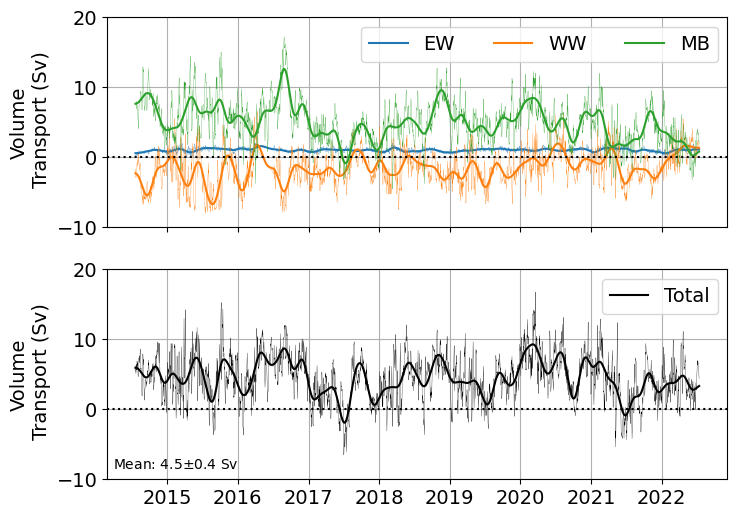

In [34]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
ds_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
ds_Q_Qh_Qf.Q_lp_EW.plot.line(ax=ax,color='C0',label='EW')

ds_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
ds_Q_Qh_Qf.Q_lp_WW.plot.line(ax=ax,color='C1',label='WW')

ds_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
ds_Q_Qh_Qf.Q_lp_MB.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
ds_Q_Qh_Qf.Q_total.plot.line('k',ax=ax,linewidth=.2)
ds_Q_Qh_Qf.Q_total_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, 
        ('Mean: %2.1f$\pm$%2.1f Sv' %(ds_Q_Qh_Qf.Q_total.mean().values,ds_Q_Qh_Qf.Q_total_SE.values)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[0])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-10, 20])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_volume_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Heat Transport

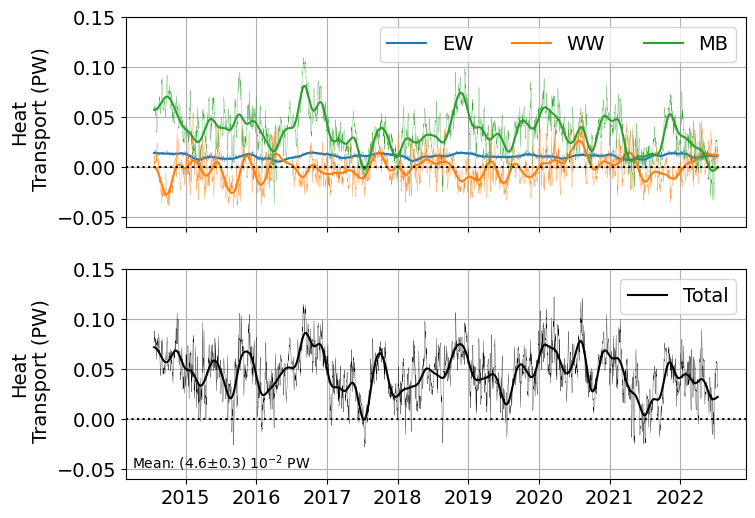

In [35]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
ds_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
ds_Q_Qh_Qf.Qh_lp_EW.plot.line(ax=ax,color='C0',label='EW')

ds_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
ds_Q_Qh_Qf.Qh_lp_WW.plot.line(ax=ax,color='C1',label='WW')

ds_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
ds_Q_Qh_Qf.Qh_lp_MB.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
ds_Q_Qh_Qf.Qh_total.plot.line('k',ax=ax,linewidth=.2)
ds_Q_Qh_Qf.Qh_total_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(ds_Q_Qh_Qf.Qh_total.mean().values*1e2,ds_Q_Qh_Qf.Qh_total_SE.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[1])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .15])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_heat_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Freshwater Transport

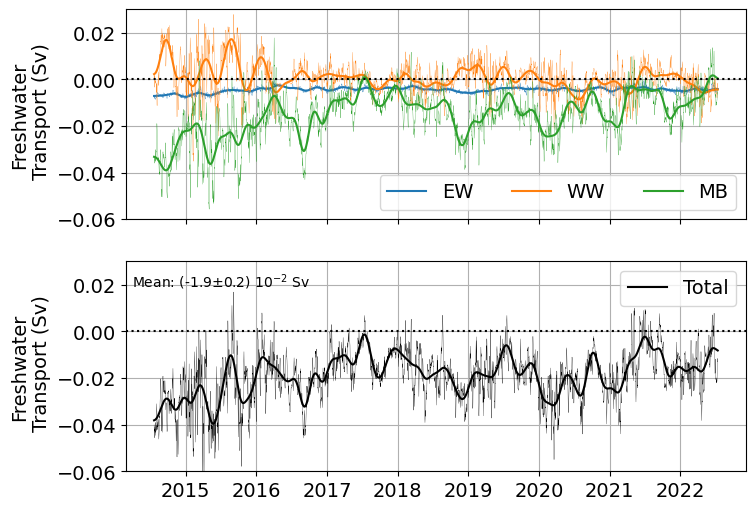

In [36]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .95

ax=axs[0]
ds_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
ds_Q_Qh_Qf.Qf_lp_EW.plot.line(ax=ax,color='C0',label='EW')

ds_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
ds_Q_Qh_Qf.Qf_lp_WW.plot.line(ax=ax,color='C1',label='WW')

ds_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
ds_Q_Qh_Qf.Qf_lp_MB.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
ds_Q_Qh_Qf.Qf_total.plot.line('k',ax=ax,linewidth=.2)
ds_Q_Qh_Qf.Qf_total_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(ds_Q_Qh_Qf.Qf_total.mean().values*1e2,ds_Q_Qh_Qf.Qf_total_SE.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[2])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .03])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_freshwater_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Total Transport Timeseries

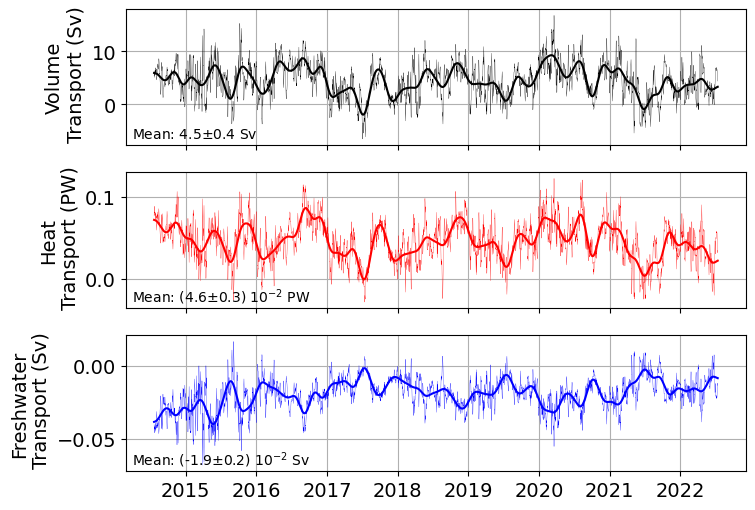

In [37]:
fig,axs = plt.subplots(3,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

# print(SE.values)
# print(SEh.values)
# print(SEf.values) Q_MB_grid

ds_Q_Qh_Qf.Q_total.plot.line('k',ax=axs[0],linewidth=.2)
ds_Q_Qh_Qf.Q_total_lp.plot.line('k',ax=axs[0],)
axs[0].text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(ds_Q_Qh_Qf.Q_total.mean().values,ds_Q_Qh_Qf.Q_total_SE.values)),
        fontsize=10,
        transform=axs[0].transAxes)

ds_Q_Qh_Qf.Qh_total.plot.line('r',ax=axs[1],linewidth=.2)
ds_Q_Qh_Qf.Qh_total_lp.plot.line('r',ax=axs[1],)
axs[1].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(ds_Q_Qh_Qf.Qh_total.mean().values*1e2,ds_Q_Qh_Qf.Qh_total_SE.values*1e2)),
        fontsize=10,
        transform=axs[1].transAxes)

ds_Q_Qh_Qf.Qf_total.plot.line('b',ax=axs[2],linewidth=.2)
ds_Q_Qh_Qf.Qf_total_lp.plot.line('b',ax=axs[2],)
axs[2].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(ds_Q_Qh_Qf.Qf_total.mean().values*1e2,ds_Q_Qh_Qf.Qf_total_SE.values*1e2)),
        fontsize=10,
        transform=axs[2].transAxes)

for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[i])
    ax.set_xlabel('')

fig.savefig(fig_out_path/f'Rockall_Trough_total_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Mean Sections

In [38]:
ds_RT_grid = rtf.calc_sigma0_grid(ds_RT_grid)

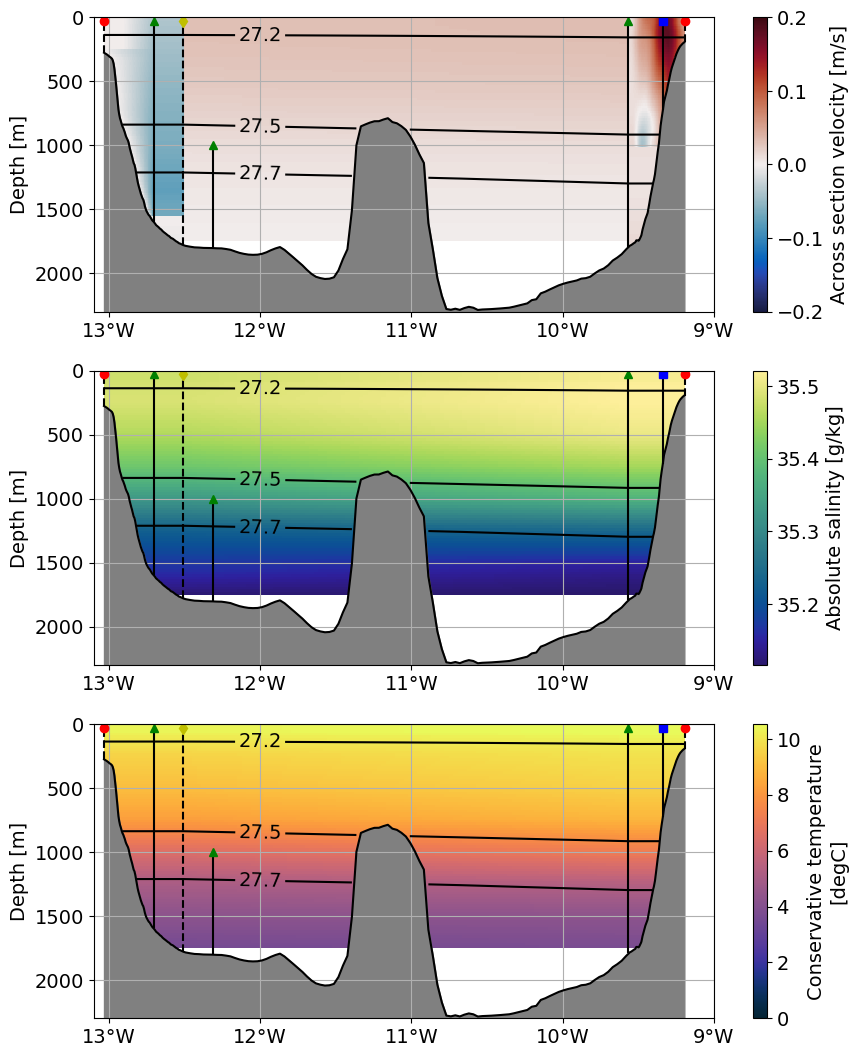

In [39]:
## figure
plt.rcParams.update({'font.size': 14})

xticks = np.arange(-13.,-8,1)
xticklabels = ['13°W','12°W','11°W','10°W','9°W']

sigma_contours = [27.2,27.5, 27.7]
manual_locations = [(-12,100),(-12,900),(-12,1250)]

# Set up figure
fig,axs = plt.subplots(3,1,figsize=[10,13])

ds_RT_grid.v.mean('TIME',keep_attrs=True).plot(
    ax=axs[0],y='depth',x='lon',yincrease=False,cmap=cm.cm.balance,vmin=-0.2,vmax=0.2)
ds_RT_grid.SA.mean('TIME',keep_attrs=True).plot(
    ax=axs[1],y='depth',x='lon',yincrease=False,cmap=cm.cm.haline)
ds_RT_grid.CT.mean('TIME',keep_attrs=True).plot(
    ax=axs[2],y='depth',x='lon',yincrease=False,cmap=cm.cm.thermal,vmin=0)

for ax in axs:
    ax.fill_between(ds_RT_grid.lon, -ds_RT_grid.bathy,2300,color='grey')
    (-ds_RT_grid.bathy).plot.line('k',ax=ax)
    CS = ds_RT_grid.sigma0.mean('TIME',keep_attrs=True).where(ds_RT_grid.depth<=-ds_RT_grid.bathy).plot.contour(
        ax=ax,x='lon',levels=sigma_contours,yincrease=False,colors='k')
    ax.clabel(CS,manual=manual_locations)
    
    ax.vlines(ds_RT_loc.lon_RTWB,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(ds_RT_loc.lon_RTES,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(ds_RT_loc.lon_RTWS,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
    
    ax.vlines(ds_RT_loc.lon_RTADCP,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
    ax.vlines(ds_RT_loc.lon_RTEB,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
    ax.vlines(ds_RT_loc.lon_RTWB1,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')
    ax.vlines(ds_RT_loc.lon_RTWB2,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTWB2,method='nearest'), 1000,colors='k')
    
    d= 30.
    ax.plot([ds_RT_loc.lon_RTES,ds_RT_loc.lon_RTWS],[d,d],'or')
    ax.plot([ds_RT_loc.lon_RTWB],[d],'dy')
    ax.plot([ds_RT_loc.lon_RTADCP],[d],'sb')
    ax.plot([ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTWB1],[d,d],'^g')
    ax.plot([ds_RT_loc.lon_RTWB2],[1000],'^g')
    
    ax.set_xlim([-13.1,-9.])
    ax.set_xlabel('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=14)
    ax.grid()

    ax.set_ylabel('Depth [m]')
    ax.set_ylim([2300,0])

fig.savefig(f'{fig_out_path}Rockall_Trough_mean_sections_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## EW, WW and glider

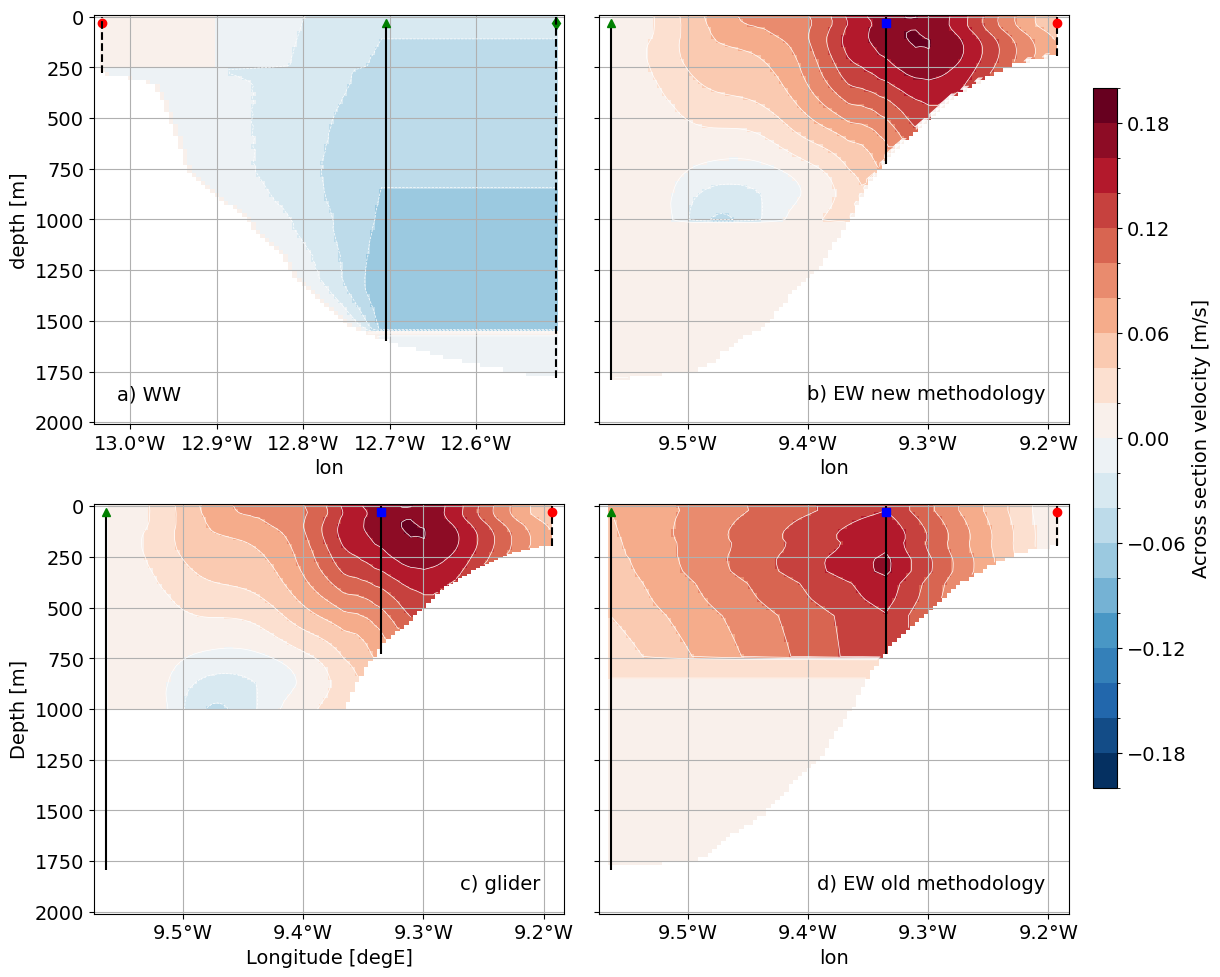

In [41]:
v_glider = ds_glider.vcur
v_glider['depth']=abs(v_glider.depth)

v_old=ds_q_RTEW_old.v

xticks_WW = np.arange(-13.,ds_RT_loc.lon_RTWB,.1)
xticklabels_WW = ['13.0°W','12.9°W','12.8°W','12.7°W','12.6°W']

xticks_EW = np.arange(-9.5,ds_RT_loc.lon_RTES,.1)
xticklabels_EW = ['9.5°W','9.4°W','9.3°W','9.2°W']

fig,axs = plt.subplots(2,2,figsize=[12,10],sharey=True)

vmin,vmax,levs=-0.2,0.2,21

ax = axs[0,0]
v = ds_RT_grid.v.sel(lon=ds_q_RTWW.lon).mean('TIME')
v.depth['long_name']='Depth'
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.plot([ds_RT_loc.lon_RTWS],[d],'or')
ax.plot([ds_RT_loc.lon_RTWB],[d],'dg')
ax.plot([ds_RT_loc.lon_RTWB1],[d],'^g')

ax.vlines(ds_RT_loc.lon_RTWB,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
ax.vlines(ds_RT_loc.lon_RTWS,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
ax.vlines(ds_RT_loc.lon_RTWB1,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')

ax.set_xlim([ds_RT_loc.lon_RTWS-0.01,ds_RT_loc.lon_RTWB+0.01])
ax.set_xticks(xticks_WW)
ax.set_xticklabels(xticklabels_WW,fontsize=14)

ax.text(0.05, 0.05,f'a) WW',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[0,1]
v = ds_RT_grid.v.sel(lon=ds_q_RTEW.lon).mean('TIME')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.95, 0.05,f'b) EW new methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='right')

ax = axs[1,0]
v = v_glider.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.95, 0.05,f'c) glider',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='right')

ax = axs[1,1]
v = v_old.mean('TIME')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)

ax.text(0.95, 0.05,f'd) EW old methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='right')

for i,ax in enumerate(axs.flat):
    ax.grid()
    if i>0:
        ax.vlines(ds_RT_loc.lon_RTADCP,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
        ax.vlines(ds_RT_loc.lon_RTEB,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
        ax.vlines(ds_RT_loc.lon_RTES,-ds_RT_grid.bathy.sel(lon=ds_RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')

        ax.plot([ds_RT_loc.lon_RTES],[d],'or')
        ax.plot([ds_RT_loc.lon_RTADCP],[d],'sb')
        ax.plot([ds_RT_loc.lon_RTEB],[d],'^g')
        
        ax.set_xlim([ds_RT_loc.lon_RTEB-0.01,ds_RT_loc.lon_RTES+0.01])
        ax.set_xticks(xticks_EW)
        ax.set_xticklabels(xticklabels_EW,fontsize=14)
        
    if i==1 or i==3:
        ax.set_ylabel('')
plt.tight_layout()
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
cb =fig.colorbar(im_hdl, cax=cbar_ax)
cb.set_label('Across section velocity [m/s]')

## RT z-integrated transports

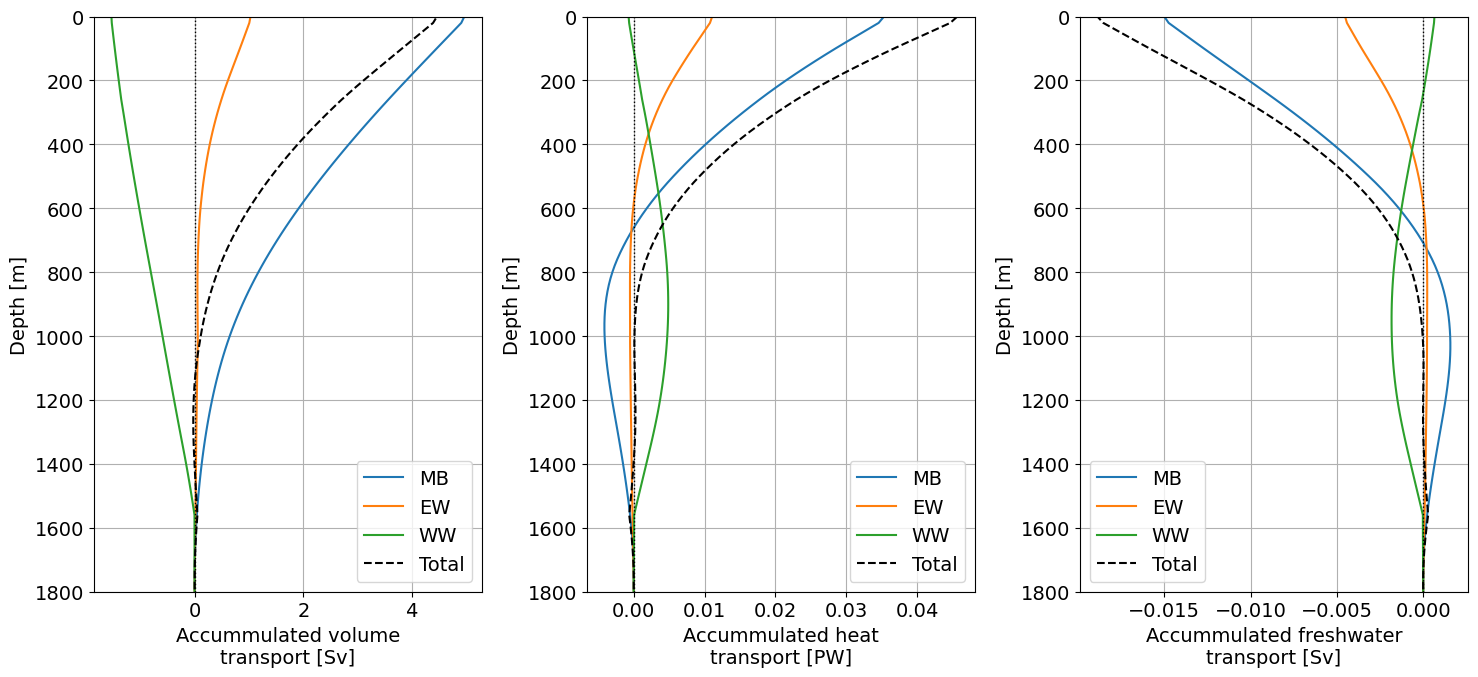

In [42]:
fig,axs = plt.subplots(1,3,figsize=[15,7])
ax=axs[0]
(ds_q_RTMB.q.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.q.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.q.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_RT_grid.q.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_RT_grid.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated volume\ntransport [Sv]')

ax=axs[1]
(ds_q_RTMB.qh.sum('lon')/1e15).mean(['TIME']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.qh.sum('lon')/1e15).mean(['TIME']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.qh.sum('lon')/1e15).mean(['TIME']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_RT_grid.qh.sum('lon')/1e15).mean(['TIME']).reindex(depth=ds_RT_grid.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated heat\ntransport [PW]')

ax=axs[2]
(ds_q_RTMB.qf.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.qf.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.qf.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_RT_grid.qf.sum('lon')/1e6).mean(['TIME']).reindex(depth=ds_RT_grid.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated freshwater\ntransport [Sv]')


for ax in axs:
    ax.axvline(0,ls=':',color='k',lw='1')
    ax.legend()
    ax.set_ylabel('Depth [m]')
    ax.grid()
    ax.set_title('')
plt.tight_layout()

fig.savefig(f'{fig_out_path}Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')